# <center>Trabajo Práctico 1 - Laboratorio de Datos - UBA FCEyN</center>
## <center>Alumnos: Orga Juan Francisco, Romero Santiago, Maspero Lucio Fabrizio</center>


El TP consta el en preprocesamiento y analisis de datos del uso de la SUBE a lo largo del pais durante el 2023. Luego, el entrenamiento de algunos modelos lineales vistos en clases con el objectivo de poder predecir la cantidad de pasajeros de una linea de colectivo en especifico con la informacion, intencionalmente seleccionadas, de otras 5 lineas. Brevemente, veamos como esta divido el TP:

- Procesamiento de Datos
- Analasis Exploratorio 
- Modelado

Cada paso tiene su propia seccion dentro del trabajo, dentro de ellas se van a ir explicando las distintas decisiones tomados de la mejor manera posible.

Importemos los paquetes y metodos utilizados a lo la largo del trabajo practico.

In [33]:
# Manipulacion de Datos y demas
import pandas as pd
import numpy as np
from gapminder import gapminder
from formulaic import Formula
import calendar

# Visualizacion de Datos
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Preprocesamiento de los Datos
from sklearn.preprocessing import StandardScaler

# Modelado de los Datos
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge

import warnings
warnings.filterwarnings("ignore")

## Procesamiento de Datos

Trabajaremos con el dataset sube-2023.csv que contiene datos sobre la utilización de la SUBE durante el año 2023 a nivel nacional.

In [34]:
datos = pd.read_csv('./sube-2023.csv')

Vamos a hacer una visualización general de los datos, para tener una idea de con qué valores, qué datos y qué tipo de datos tenemos.

In [35]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472291 entries, 0 to 472290
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   472291 non-null  object
 1   NOMBRE_EMPRESA   472291 non-null  object
 2   LINEA            472291 non-null  object
 3   AMBA             472291 non-null  object
 4   TIPO_TRANSPORTE  472291 non-null  object
 5   JURISDICCION     469742 non-null  object
 6   PROVINCIA        469720 non-null  object
 7   MUNICIPIO        469720 non-null  object
 8   CANTIDAD         472291 non-null  int64 
 9   DATO_PRELIMINAR  472291 non-null  object
dtypes: int64(1), object(9)
memory usage: 36.0+ MB


In [36]:
datos.describe()

,CANTIDAD
count,472291.000000
mean,9336.927454
std,20609.074234
min,-417.000000
25%,683.000000
50%,2627.000000
75%,9062.000000
max,542616.000000


In [37]:
datos.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO


Como análisis exploratorio vamos a ver de qué provincia tenemos datos.

In [38]:
provincias_datos =  datos['PROVINCIA'].unique()
print(provincias_datos)
datos['PROVINCIA'] = datos['PROVINCIA'].replace('CORDOBA', 'CÓRDOBA')

['BUENOS AIRES' 'JN' 'CHUBUT' nan 'SANTA FE' 'ENTRE RÍOS' 'LA PAMPA'
 'MENDOZA' 'RÍO NEGRO' 'TIERRA DEL FUEGO' 'CHACO' 'JUJUY' 'NEUQUÉN'
 'FORMOSA' 'CORRIENTES' 'CATAMARCA' 'SAN JUAN' 'SAN LUIS' 'CORDOBA'
 'SANTA CRUZ' 'SANTIAGO DEL ESTERO']


- Podemos ver que tenemos en estos datos, "nan" y "JN"
- "JN" está definido por el proveedor de los datos (Datos abiertos de la Secreataría de Transporte) como la Ciudad Autónoma de Bs As.
- "nan" es una provincia la cual no tenemos pleno conocimiento. Por lo que la vamos a retirar del df. Al hacer esto tenemos que tener en cuenta que en el caso de los subtes, esta columna siempre es NaN, por lo que vamos a limpiar los datos de esta "provincia" (nan) siempre y cuando TIPO_TRANSPORTE no sea SUBTE.

Veamos entonces, para conocer por completo nuestra región, qué provincias están o no en nuestros datos:

In [39]:
# Lista de provincias
provinciasArgentina = [
  "BUENOS AIRES", "CATAMARCA", "CHACO", "CHUBUT", "CÓRDOBA",
  "CORRIENTES", "ENTRE RÍOS", "FORMOSA", "JUJUY", "LA PAMPA",
  "LA RIOJA", "MENDOZA", "MISIONES", "NEUQUÉN", "RÍO NEGRO",
  "SALTA", "SAN JUAN", "SAN LUIS", "SANTA CRUZ", "SANTA FE",
  "SANTIAGO DEL ESTERO", "TIERRA DEL FUEGO",
  "TUCUMÁN"
]

# Array proporcionado
provincias_datos =  datos['PROVINCIA'].unique()

# Convertir los arrays a conjuntos, eliminando NaN
set_provinciasArgentina = set(provinciasArgentina)
set_provincias_datos = {x for x in provincias_datos if (x)}

# Encontrar diferencias
diferencias_en_proporcionado = set_provincias_datos.difference(set_provinciasArgentina)
diferencias_en_provincias = set_provinciasArgentina.difference(set_provincias_datos)

print("Provincias en nuestros datos pero no en provinciasArgentina:", diferencias_en_proporcionado)
print("Provincias en provinciasArgentina pero no en nuestros datos:", diferencias_en_provincias)

Provincias en nuestros datos pero no en provinciasArgentina: {'JN', nan}
Provincias en provinciasArgentina pero no en nuestros datos: {'SALTA', 'LA RIOJA', 'MISIONES', 'TUCUMÁN'}


Esto nos indicaría que o no tenemos datos de esas provincias, o que estas provincias no cuentan con el servicio de SUBE. Como nuestro proveedor de datos no especifica esto, vamos a considerar que no tienen servicio SUBE, pero esto igualmente sigue siendo relevante para nosotros.

In [40]:
#Limpieza de datos:
datos = datos[~datos['PROVINCIA'].isnull() & datos['TIPO_TRANSPORTE'] != 'SUBTE'].reset_index()

# display(datos[datos['TIPO_TRANSPORTE'] == 'SUBTE'])  ## esta bien que no sea un df vacio.

*(1a) Visualizar el tipo de datos de cada columna. Transformar la columna DIA_TRANSPORTE para que sea reconocida como una fecha.
Sugerencia: investigar la función to_datetime de pandas. Para completar el argumento format, revisar la documentación de datetime.*

Los distintos tipos de datos de cada columna fueron previamente vistos en el output del metodo 'info()'. Seguimos directamente con la transformacion de la columns 'DIA_TRANSPORTE'.

In [41]:
datos['DIA_TRANSPORTE'] = pd.to_datetime(datos['DIA_TRANSPORTE'], format='%Y-%m-%d')

*(1b) Agregar tres columnas al DataFrame:*

*- FECHA_DIA : debe indicar el nombre del día de la semana correspondiente a DIA_TRANSPORTE*

*- FECHA_ORDINAL : debe indicar el ordinal correspondiente a DIA_TRANSPORTE (por ejemplo, a 2023-01-01 le corresponde 1, a 2023-01-02 le corresponde 2 y así sucesivamente). Debe ser un entero (int).*

*- FECHA_MES : debe indicar el mes correspondiente a DIA_TRANSPORTE Sugerencia: investigar el método apply de DataFrame.*

In [42]:
# Diccionario para traducir los días de la semana
dias_semana = {
    'Monday': 'Mon',
    'Tuesday': 'Tue',
    'Wednesday': 'Wed',
    'Thursday': 'Thu',
    'Friday': 'Fri',
    'Saturday': 'Sat',
    'Sunday': 'Sun'
}

# Agregar una nueva columna 'FECHA_DIA' con el nombre del día de la semana
datos['FECHA_DIA'] = datos['DIA_TRANSPORTE'].dt.day_name().map(dias_semana)

In [43]:
# Calcular el ordinal de la fecha
fecha_base = pd.Timestamp('2023-01-01') #primer fecha del anio

datos['FECHA_ORDINAL'] = datos['DIA_TRANSPORTE'].dt.dayofyear

# Asegurarse de que la nueva columna sea de tipo int
datos['FECHA_ORDINAL'] = datos['FECHA_ORDINAL'].astype(int)

In [44]:
# Agregar la columna 'FECHA_MES' con el número del mes en formato 'MM'
datos['FECHA_MES'] = datos['DIA_TRANSPORTE'].dt.month.apply(lambda x: f'{x:02d}')

*(2) Crear el DataFrame datos_amba, el cual sólo debe tener datos de AMBA y debe excluir datos preliminares. Además, al ejecutar datos_amba.head() debe observarse el siguiente orden y formato de columnas.*

In [45]:
#Verificamos que los valores vistos en los datos sean unicamente "SI" y "NO"
datos['AMBA'].unique()

array(['SI', 'NO'], dtype=object)

In [46]:
#Armamos nuevo df con sólo los datos de AMBA
datos_amba = datos[datos.AMBA == 'SI']

In [47]:
# Lista de nombres de columnas en el orden deseado
orden_columnas = ['DIA_TRANSPORTE', 'FECHA_DIA', 'FECHA_MES','FECHA_ORDINAL','JURISDICCION','LINEA','CANTIDAD','TIPO_TRANSPORTE']

# Reorganizar las columnas
datos_amba = datos_amba[orden_columnas]
# datos_amba.head()
datos_amba.rename(columns={'DIA_TRANSPORTE': 'fecha', 'FECHA_DIA': 'fecha_dia', 'FECHA_MES':'fecha_mes', 'FECHA_ORDINAL':'fecha_ordinal', 'JURISDICCION':'jurisdiccion', 'LINEA':'linea', 'CANTIDAD':'pasajeros','TIPO_TRANSPORTE':'tipo_transporte'}, inplace=True)

*(3) Utilizando datos_amba, identificar:*

*- (a) La proporción de la cantidad total anual de pasajeros que le corresponde a cada medio de transporte.*

*- (b) la tupla (mes, línea de subte) donde viajó la mayor cantidad de pasajeros.*

*- (c) el día hábil con menor desvío estándar en cantidad de pasajeros.*

In [48]:
# Ya habiamos verificado que 'pasajeros' sea de tipo numerico
# Agrupamos los datos por 'tipo_transporte' y sumamos la cantidad de pasajeros por cada tipo
suma_por_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum()

# Calculamos el total anual de pasajeros
total_anual = suma_por_transporte.sum()

# Calculamos la proporción de pasajeros por cada tipo de transporte
proporcion_por_transporte = suma_por_transporte / total_anual

# Resultado
print(proporcion_por_transporte)

tipo_transporte
COLECTIVO    0.837677
SUBTE        0.068084
TREN         0.094240
Name: pasajeros, dtype: float64


Podemos ver que aproximadamente el 83.8% del total anual de pasajeros fue en COLECTIVO, el 6.8% en SUBTE y un ~9.4% en TREN en el AMBA.

In [49]:
# Filtrar los datos para incluir solo las líneas de subte (asumiendo que se identifican por la palabra 'subte' en 'TIPO_TRANSPORTE')
subte_datos = datos_amba[datos_amba['tipo_transporte'].str.contains('SUBTE', case=False, na=False)]

# Agrupar los datos por 'MES' y 'LINEA' y sumar la cantidad de pasajeros
suma_por_mes_linea = subte_datos.groupby(['fecha_mes', 'linea'])['pasajeros'].sum().reset_index()

# Crear un DataFrame con los valores de suma_por_mes_linea
df_suma_por_mes_linea = pd.DataFrame(suma_por_mes_linea, columns=['fecha_mes', 'linea', 'pasajeros'])

Tenemos que tener en cuenta que si hay más de un valor máximo (si justo dos lineas tienen el mismo numero de pasajeros, tenerlo en cuenta). Por eso la logica utilizada.

In [50]:
# Encontrar la tupla (mes, línea de subte) con la mayor cantidad de pasajeros
tupla_max_pasajeros = suma_por_mes_linea['pasajeros'].idxmax()
max_pasajeros = df_suma_por_mes_linea['pasajeros'].max()

suma_por_mes_linea_unico = suma_por_mes_linea[suma_por_mes_linea['pasajeros'] == max_pasajeros]

# Verificamos que hay un unico valor maximo de pasajeros:
# print(suma_por_mes_linea_unico)

tupla_mes_max = (suma_por_mes_linea_unico.fecha_mes.item(), suma_por_mes_linea_unico.pasajeros.item())

# print(tupla_mes_max)
# print(type(tupla_mes_max))

# Entonces mostramos el resultado de la tupla
print(f"Tupla (mes, línea de subte) con la mayor cantidad de pasajeros: {tupla_mes_max[0]} con {tupla_mes_max[1]} pasajeros")

Tupla (mes, línea de subte) con la mayor cantidad de pasajeros: 08 con 5227906 pasajeros


In [51]:
# Filtrar los datos para incluir solo días hábiles (lunes a viernes)
dias_habiles = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
datos_habiles = datos_amba[datos_amba['fecha_dia'].isin(dias_habiles)]

# Agrupar los datos por el nombre del día de la semana y calcular el desvío estándar de la cantidad de pasajeros para cada día
desvio_estandar_por_dia = datos_habiles.groupby('fecha_dia')['pasajeros'].std()

# Chequeamos nuevamente que el valor de mínimo std sea único:
df_desvio_estandar_por_dia = pd.DataFrame(desvio_estandar_por_dia.reset_index()).rename(columns={'pasajeros': 'std'})
# print(df_desvio_estandar_por_dia) 

In [52]:
# Encontrar el día hábil con el menor desvío estándar
dia_menor_desvio_estandar = desvio_estandar_por_dia.idxmin()
menor_desvio_estandar = desvio_estandar_por_dia.min()
print(f"El día hábil con menor desvío estándar en cantidad de pasajeros es: {dia_menor_desvio_estandar} con un desvío estándar de {menor_desvio_estandar}")

El día hábil con menor desvío estándar en cantidad de pasajeros es: Mon con un desvío estándar de 33573.89534333799


## Análisis Exploratorio

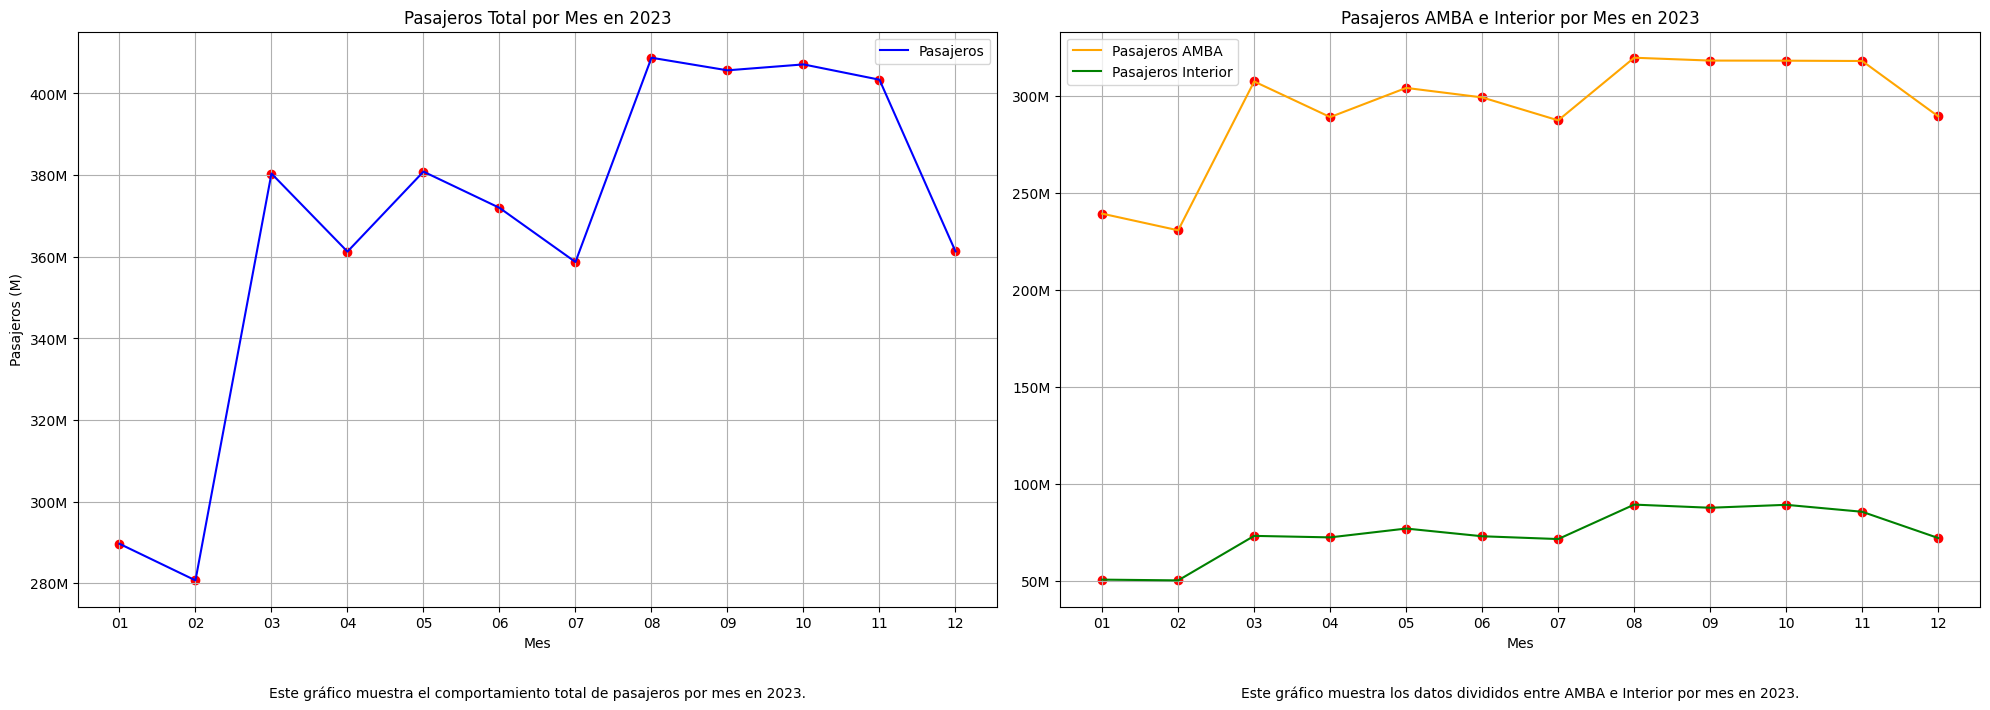

In [53]:
# Filtrar los datos
datosAMBA = datos[datos['AMBA'] == 'SI']
datosINT = datos[datos['AMBA'] == 'NO']

# Agrupar los datos por mes y sumar la cantidad
datos_agg = datos.groupby('FECHA_MES')['CANTIDAD'].sum().reset_index()
datos_aggAMBA = datosAMBA.groupby('FECHA_MES')['CANTIDAD'].sum().reset_index()
datos_aggINT = datosINT.groupby('FECHA_MES')['CANTIDAD'].sum().reset_index()

# Función para formatear los valores del eje Y
def millones(x, pos):
    return f'{x * 1e-6:.0f}M'

formatter = FuncFormatter(millones)

# Crear una figura con dos subplots dispuestos horizontalmente
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Primer gráfico: Pasajeros Total
ax1.plot(datos_agg['FECHA_MES'], datos_agg['CANTIDAD'], label='Pasajeros', color='blue')
ax1.scatter(datos_agg['FECHA_MES'], datos_agg['CANTIDAD'], color='red')
ax1.set_title('Pasajeros Total por Mes en 2023')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Pasajeros (M)')
ax1.legend()
ax1.grid(True)
ax1.yaxis.set_major_formatter(formatter)

# Descripción específica para el primer gráfico
ax1.text(0.5, -0.15, 'Este gráfico muestra el comportamiento total de pasajeros por mes en 2023.',
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=10)

# Segundo gráfico: Pasajeros AMBA e Interior
ax2.plot(datos_aggAMBA['FECHA_MES'], datos_aggAMBA['CANTIDAD'], label='Pasajeros AMBA', color='orange')
ax2.plot(datos_aggINT['FECHA_MES'], datos_aggINT['CANTIDAD'], label='Pasajeros Interior', color='green')
ax2.scatter(datos_aggAMBA['FECHA_MES'], datos_aggAMBA['CANTIDAD'], color='red')
ax2.scatter(datos_aggINT['FECHA_MES'], datos_aggINT['CANTIDAD'], color='red')
ax2.set_title('Pasajeros AMBA e Interior por Mes en 2023')
ax2.set_xlabel('Mes')
ax2.legend()
ax2.grid(True)
ax2.yaxis.set_major_formatter(formatter)

# Descripción específica para el segundo gráfico
ax2.text(0.5, -0.15, 'Este gráfico muestra los datos divididos entre AMBA e Interior por mes en 2023.',
         horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=10)

# Ajustar el layout
plt.tight_layout(rect=[0, 0.2, 1, 0.95])
plt.show()


Podemos observar la diferencia de volumen entre el AMBA y el Interior. También se puede destacar que el comportamiento es similar en ambos (identificando el aumento y disminución del uso de transporte público en los mismos meses para los distintos sectores del país).

Veamos ahora el comportamiento por transporte.


In [54]:
# display(datos_aggAMBA)
datos_aggAMBA = datosAMBA.groupby(['FECHA_MES', 'TIPO_TRANSPORTE'])['CANTIDAD'].sum().reset_index()
datos_aggINT = datosINT.groupby(['FECHA_MES', 'TIPO_TRANSPORTE'])['CANTIDAD'].sum().reset_index()

In [55]:
# Creo los dataframes para plotear los valores de los transportes de las localidades
datos_aggAMBA_colectivo = datos_aggAMBA[datos_aggAMBA['TIPO_TRANSPORTE'] == 'COLECTIVO']
datos_aggAMBA_subte = datos_aggAMBA[datos_aggAMBA['TIPO_TRANSPORTE'] == 'SUBTE']
datos_aggAMBA_tren = datos_aggAMBA[datos_aggAMBA['TIPO_TRANSPORTE'] == 'TREN']

datos_aggINT_colectivo = datos_aggINT[datos_aggINT['TIPO_TRANSPORTE'] == 'COLECTIVO']
datos_aggINT_lanchas = datos_aggINT[datos_aggINT['TIPO_TRANSPORTE'] == 'LANCHAS']
datos_aggINT_tren = datos_aggINT[datos_aggINT['TIPO_TRANSPORTE'] == 'TREN']

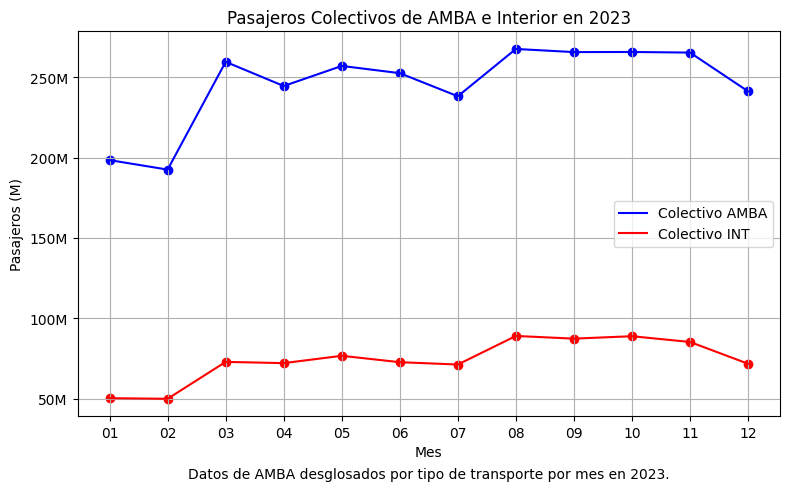

In [56]:
# Creamos la figura
fig, ax1 = plt.subplots(figsize=(8, 7))

# Acomodamos la data
ax1.plot(datos_aggAMBA_colectivo['FECHA_MES'], datos_aggAMBA_colectivo['CANTIDAD'], label='Colectivo AMBA', color='blue')
ax1.scatter(datos_aggAMBA_colectivo['FECHA_MES'], datos_aggAMBA_colectivo['CANTIDAD'], color='blue')
ax1.plot(datos_aggINT_colectivo['FECHA_MES'], datos_aggINT_colectivo['CANTIDAD'], label='Colectivo INT', color='red')
ax1.scatter(datos_aggINT_colectivo['FECHA_MES'], datos_aggINT_colectivo['CANTIDAD'], color='red')
ax1.set_title('Pasajeros Colectivos de AMBA e Interior en 2023')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Pasajeros (M)')
ax1.legend()
ax1.grid(True)
ax1.yaxis.set_major_formatter(formatter)

# Agregamos Descripcion
plt.text(0.5, -0.15, 'Datos de AMBA desglosados por tipo de transporte por mes en 2023.',
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=10)

# Ajustamos el 'layout'
plt.tight_layout(rect=[0, 0.2, 1, 0.95])
plt.show()


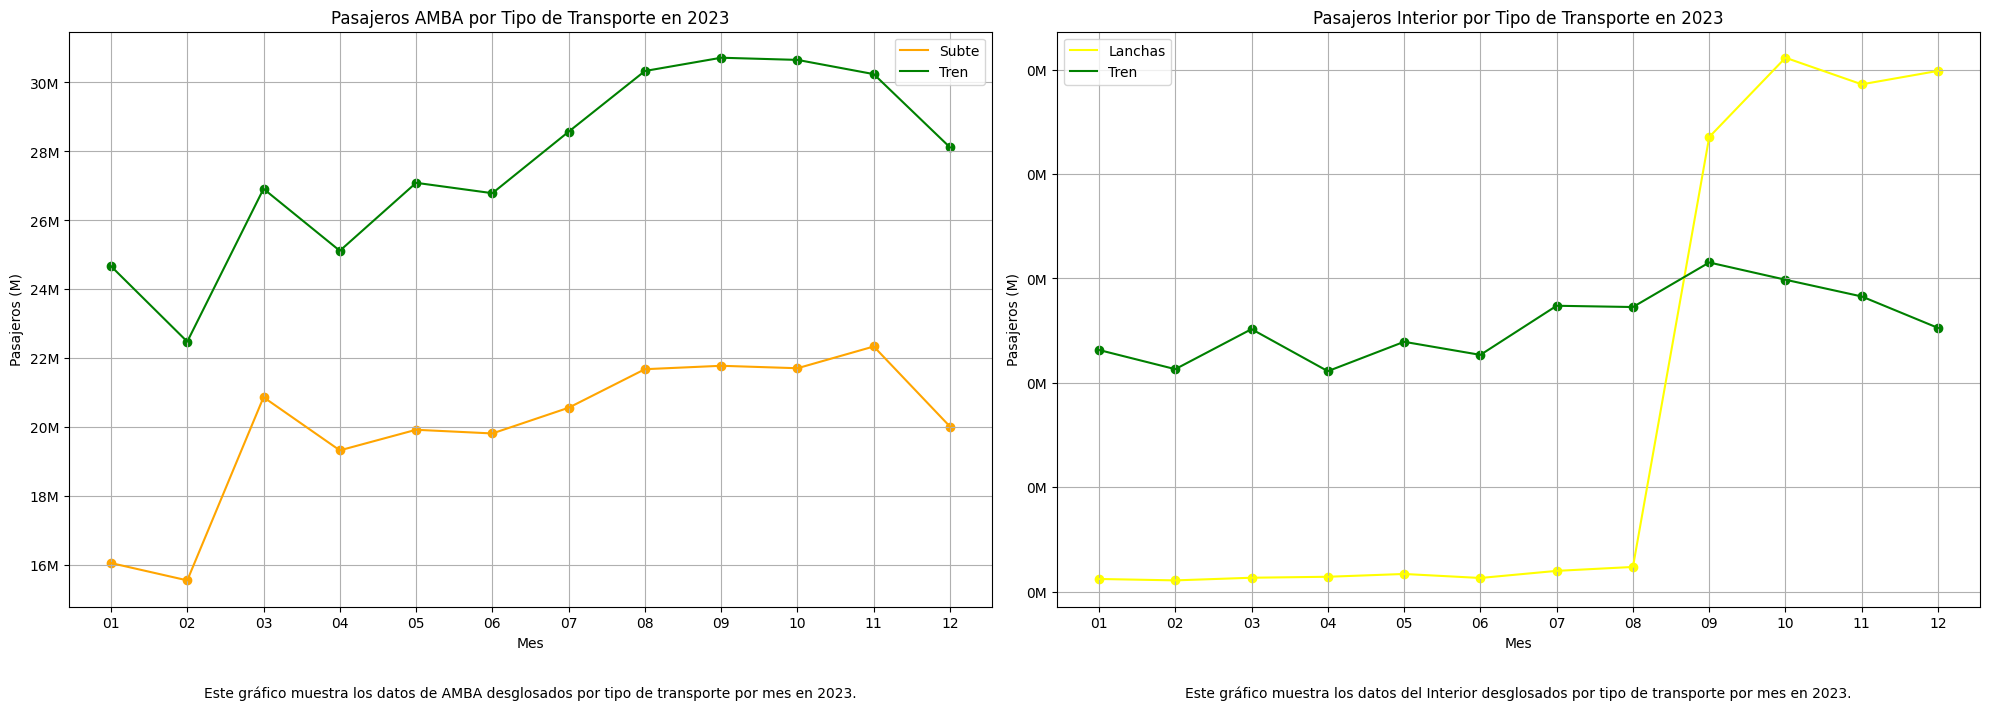

In [57]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Primer gráfico: Pasajeros AMBA desglosados por tipo de transporte
ax1.plot(datos_aggAMBA_subte['FECHA_MES'], datos_aggAMBA_subte['CANTIDAD'], label='Subte', color='orange')
ax1.plot(datos_aggAMBA_tren['FECHA_MES'], datos_aggAMBA_tren['CANTIDAD'], label='Tren', color='green')
ax1.scatter(datos_aggAMBA_subte['FECHA_MES'], datos_aggAMBA_subte['CANTIDAD'], color='orange')
ax1.scatter(datos_aggAMBA_tren['FECHA_MES'], datos_aggAMBA_tren['CANTIDAD'], color='green')
ax1.set_title('Pasajeros AMBA por Tipo de Transporte en 2023')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Pasajeros (M)')
ax1.legend()
ax1.grid(True)
ax1.yaxis.set_major_formatter(formatter)

# Descripción específica para el primer gráfico
ax1.text(0.5, -0.15, 'Este gráfico muestra los datos de AMBA desglosados por tipo de transporte por mes en 2023.',
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=10)

# Segundo gráfico: Pasajeros Interior desglosados por tipo de transporte
ax2.plot(datos_aggINT_lanchas['FECHA_MES'], datos_aggINT_lanchas['CANTIDAD'], label='Lanchas', color='yellow')
ax2.plot(datos_aggINT_tren['FECHA_MES'], datos_aggINT_tren['CANTIDAD'], label='Tren', color='green')
ax2.scatter(datos_aggINT_lanchas['FECHA_MES'], datos_aggINT_lanchas['CANTIDAD'], color='yellow')
ax2.scatter(datos_aggINT_tren['FECHA_MES'], datos_aggINT_tren['CANTIDAD'], color='green')
ax2.set_title('Pasajeros Interior por Tipo de Transporte en 2023')
ax2.set_xlabel('Mes')
ax2.set_ylabel('Pasajeros (M)')
ax2.legend()
ax2.grid(True)
ax2.yaxis.set_major_formatter(formatter)

# Descripción específica para el segundo gráfico
ax2.text(0.5, -0.15, 'Este gráfico muestra los datos del Interior desglosados por tipo de transporte por mes en 2023.',
         horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=10)

# Ajustar el layout
plt.tight_layout(rect=[0, 0.2, 1, 0.95])
plt.show()

Separamos los gráficos de COLECTIVO y los demás transportes por la gran diferencia de volumen. Pudiendo así apreciar los gráficos con sus respectivas escalas.

Veamos cómo difiere el uso del transporte público durante los días hábiles en comparación a los fines de semana.

In [58]:
#display(datos_habiles['pasajeros'].describe())
pasajeros_datos_habiles = datos_habiles['pasajeros']

# Calcular IQR y definir umbrales para detectar outliers
Q1 = pasajeros_datos_habiles.describe()['25%']
Q3 = pasajeros_datos_habiles.describe()['75%']
IQR = Q3 - Q1
bigote_izq = Q1 - 1.5 * IQR
bigote_der = Q3 + 1.5 * IQR

# Identificar outliers
outliers = datos_habiles[(pasajeros_datos_habiles < bigote_izq) | (pasajeros_datos_habiles > bigote_der)]
print(outliers.pasajeros.count())
# display(outliers.groupby('fecha').apply(lambda x:x))

5777


Podemos ver que hay 5777 outliers, veamoslo en un boxplot

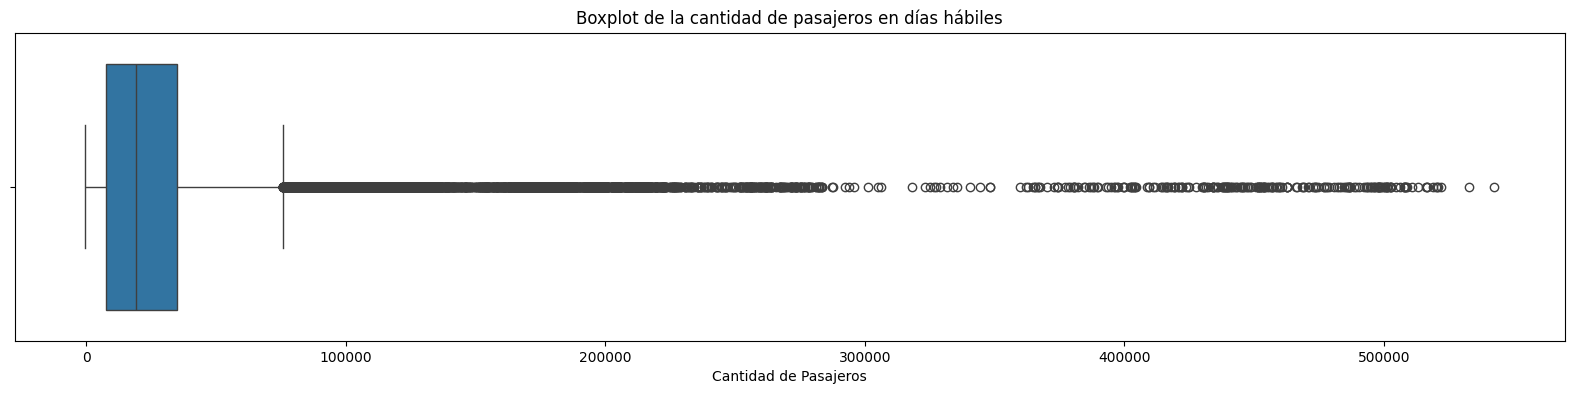

In [59]:
# Visualizar los outliers con un boxplot
plt.figure(figsize=(20, 4))
sns.boxplot(x='pasajeros', data=datos_habiles[pasajeros_datos_habiles < 10000000]) #los outliers estan a partir de 10k
plt.title('Boxplot de la cantidad de pasajeros en días hábiles')
plt.xlabel('Cantidad de Pasajeros')
plt.show()

Veamos si algun día hábil es un outlier, agrupando los datos por ellos.

In [60]:
# display(outliers)
outliers[['fecha', 'pasajeros', 'fecha_dia']].groupby('fecha_dia')['pasajeros'].describe()

,count,mean,std,min,25%,50%,75%,max
fecha_dia,,,,,,,,
Fri,1158.0,130540.250432,78495.202243,75887.0,83976.0,102237.0,133074.5,522095.0
Mon,991.0,132302.330979,79657.868787,75885.0,85613.5,105683.0,139076.5,516564.0
Thu,1197.0,132795.070175,80354.616724,75869.0,85991.0,103529.0,136406.0,542616.0
Tue,1188.0,132465.273569,80525.076561,75904.0,85832.0,104760.5,136067.0,518977.0
Wed,1243.0,131078.454545,79270.483513,75878.0,84803.0,103841.0,134495.5,520898.0


Podemos ver que todos tienen una distribución parecida.

In [61]:
datos_colectivoJN = datosAMBA[(datosAMBA['TIPO_TRANSPORTE'] == 'COLECTIVO') & (datosAMBA['PROVINCIA'] == 'JN')]
cols = datos_colectivoJN['LINEA'].unique()

pasajeros_por_linea = pd.DataFrame()
for col in cols:
    datos_linea = datos_colectivoJN[datos_colectivoJN['LINEA'] == col][['DIA_TRANSPORTE', 'CANTIDAD']]
    datos_linea = datos_linea.set_index('DIA_TRANSPORTE').rename(columns={'CANTIDAD': col})
    pasajeros_por_linea = pd.concat([pasajeros_por_linea, datos_linea], axis=1)

pasajeros_por_linea = pasajeros_por_linea.dropna(axis=1)

# print(datos_colectivoJN.LINEA.unique()) # Printeo para elegir qué lineas tomar

Se nos ocurrió hacer un gráfico de distribución de uso del sistema SUBE en el país, vamos a usar la librería de geopandas.

In [62]:
# !pip install geopandas matplotlib

In [63]:
import geopandas as gpd

# Ruta al archivo .shp
shapefile_path = './gadm41_ARG_shp/gadm41_ARG_2.shp'

# Cargar shapefile de Argentina
argentina_shapefile = gpd.read_file(shapefile_path)

# Verificar las columnas disponibles
print(argentina_shapefile.columns)


Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry'],
      dtype='object')


Tengamos en cuenta que geopandas no tiene separado CABA de las provinicas, por lo que vamos a unificar "JN" con "BUENOS AIRES". Para hacer un gráfico visual de la proporción hay que tener en cuenta la población de cada provincia.

Preparemos los datos:

In [64]:
# Cargar shapefile de Argentina
argentina_shapefile = gpd.read_file('./gadm41_ARG_shp/gadm41_ARG_1.shp')

# Normalizar los nombres de las provincias para asegurar coincidencias
argentina_shapefile['NAME_1'] = argentina_shapefile['NAME_1'].str.upper().str.strip()
datos_JN_BsAs = datos.copy()

datos_JN_BsAs['PROVINCIA'] = datos_JN_BsAs['PROVINCIA'].replace('JN', 'BUENOS AIRES')

datos_JN_BsAs['PROVINCIA'] = datos_JN_BsAs['PROVINCIA'].str.upper().str.strip()

# Agrupar los datos por región/provincia y sumar la cantidad de pasajeros
uso_por_zona = datos_JN_BsAs.groupby('PROVINCIA')['CANTIDAD'].sum().reset_index()


OBS: Sacamos la poblacion de la página del censo 2022: https://censo.gob.ar/index.php/datos_definitivos_total_pais/

In [65]:
poblacion = pd.read_excel('./c2022_tp_c_resumen.xlsx', sheet_name='cuadro_resumen', skiprows=2)
# Redefinimos las columnas para evitar errores. Y seleccionamos solo las columnas relevantes: 'Jurisdicción' y 'Total de población'
poblacion.columns = [
    'Jurisdicción', 'Total de población', 'Población en viviendas particulares',
    'Población en viviendas colectivas (¹)', 'Población en situación de calle(²)', 
    'Total de población (Varones)', 'Población en viviendas particulares (Varones)',
    'Población en viviendas colectivas (¹) (Varones)', 'Población en situación de calle(²) (Varones)',
    'Total de población (Mujeres)', 'Población en viviendas particulares (Mujeres)',
    'Población en viviendas colectivas (¹) (Mujeres)', 'Población en situación de calle(²) (Mujeres)'
]
poblacion = poblacion[['Jurisdicción', 'Total de población']].dropna()
# Mantenemos formato de mayusculas como veniamos usando y corregimos los nombres distintos del df nuevo
poblacion['Jurisdicción'] = poblacion['Jurisdicción'].str.upper() 
poblacion['Jurisdicción'] = poblacion['Jurisdicción'].replace('TIERRA DEL FUEGO, ANTÁRTIDA E ISLAS DEL ATLÁNTICO SUR', 'TIERRA DEL FUEGO')
poblacion['Jurisdicción'] = poblacion['Jurisdicción'].replace('RIO NEGRO', 'RÍO NEGRO')


# Vamos a sumar la población de CABA y BsAs en la fila de BUENOS AIRES
buenos_aires_population = poblacion[poblacion['Jurisdicción'] == 'BUENOS AIRES']['Total de población'].sum()
caba_population = poblacion[poblacion['Jurisdicción'] == 'CIUDAD AUTÓNOMA DE BUENOS AIRES']['Total de población'].sum()
total_population = buenos_aires_population + caba_population

# Actualizamos la población de "BUENOS AIRES"
poblacion.loc[poblacion['Jurisdicción'] == 'BUENOS AIRES', 'Total de población'] = total_population

# Realizamos la combinación de los DataFrames utilizando la columna de provincia
SUBE_poblacion = pd.merge(uso_por_zona, poblacion, left_on='PROVINCIA', right_on='Jurisdicción', how='left')

# Renombramos la columna 'Total de población' a 'Población' para mayor claridad
SUBE_poblacion = SUBE_poblacion.rename(columns={'Total de población': 'POBLACION'})

# Eliminamos la columna 'Jurisdicción' que ya no es necesaria
SUBE_poblacion = SUBE_poblacion.drop(columns=['Jurisdicción'])

In [66]:
# Normalizamos la cantidad de pasajeros con la población
SUBE_poblacion['CANTIDAD_NORMALIZADA'] = SUBE_poblacion['CANTIDAD'].astype(float) / SUBE_poblacion['POBLACION'].astype(float)
SUBE_poblacion.sort_values('POBLACION', ascending=False).head()

,PROVINCIA,CANTIDAD,POBLACION,CANTIDAD_NORMALIZADA
0,BUENOS AIRES,3434589370,20645703,166.358558
5,CÓRDOBA,36031,3840905,0.009381
16,SANTA FE,130693902,3544908,36.868066
10,MENDOZA,218523548,2043540,106.933825
6,ENTRE RÍOS,34751011,1425578,24.376787


Vamos a pintar en negro las provincias de las que no tenemos datos de uso de la SUBE.

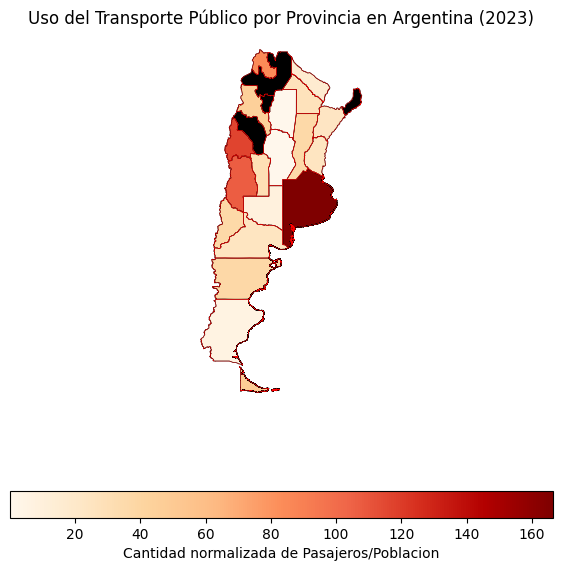

In [67]:
# Unir los datos de uso con el shapefile
argentina_shapefile = argentina_shapefile.merge(SUBE_poblacion, left_on='NAME_1', right_on='PROVINCIA', how='left')

# Crear figura y ejes para el gráfico
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Capa 1: Dibujar los datos de cantidad de pasajeros
argentina_shapefile.plot(column='CANTIDAD_NORMALIZADA', ax=ax, legend=True, cmap='OrRd',
                         legend_kwds={'label': "Cantidad normalizada de Pasajeros/Poblacion",
                                      'orientation': "horizontal"},
                         edgecolor='black', linewidth=0.5)

# Capa 2: Resaltar las provincias en negro
if 'diferencias_en_provincias' in locals():  # Verificar si existe la variable diferencias_en_provincias
    argentina_shapefile[argentina_shapefile['NAME_1'].isin(diferencias_en_provincias)].plot(ax=ax, color='black', edgecolor='black', linewidth=0.5)

# Dibujar los bordes de las provincias
argentina_shapefile.boundary.plot(ax=ax, linewidth=0.3, edgecolor='red')

# Personalizar el gráfico
ax.set_title('Uso del Transporte Público por Provincia en Argentina (2023)')
ax.set_axis_off()
plt.show()

Recordemos que la segunda provincia más poblada es Córdoba, pero tienen otro sistema único de boleto electrónico, por eso se aprecia en el mapa el color blanco a pesar de su densa población.

Lo corroboramos con la cantidad de transacciones en la provincia de Cordoba:

In [68]:
display(datos[datos['PROVINCIA'] == 'CÓRDOBA']['CANTIDAD'].nunique())

139

Analicemos la cantidad de pasajeros que usa Transporte Público por Provincia según su población.

In [69]:
# Calcular la cantidad de gente que usa transporte público por provincia
provincia_transporte = SUBE_poblacion.groupby('PROVINCIA')['CANTIDAD_NORMALIZADA'].sum().reset_index()
provincia_transporte = provincia_transporte.sort_values(by='CANTIDAD_NORMALIZADA', ascending=False)

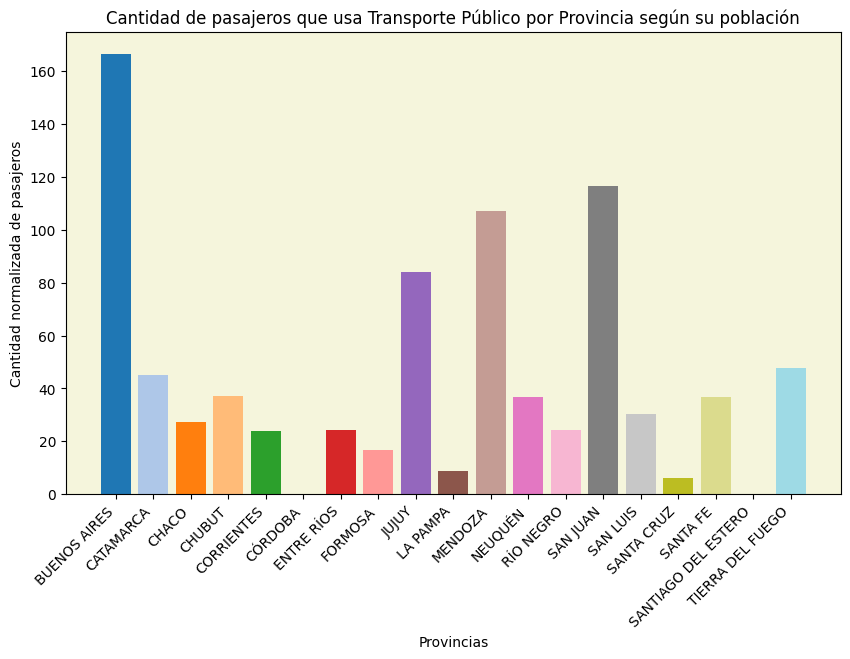

In [70]:
# Crear la paleta de colores en tonos crema
colors = plt.cm.tab20(np.linspace(0, 1, len(SUBE_poblacion)))

# Asegurarse de que la columna 'PROVINCIA' sea de tipo str
SUBE_poblacion['PROVINCIA'] = SUBE_poblacion['PROVINCIA'].astype(str)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(SUBE_poblacion['PROVINCIA'], SUBE_poblacion['CANTIDAD_NORMALIZADA'], color=colors)



# Obtener el objeto de ejes actual
ax = plt.gca()
# Cambiar el color de fondo
ax.set_facecolor('#f5f5dc')

# Añadir etiquetas y título
plt.ylabel('Cantidad normalizada de pasajeros')
plt.xlabel('Provincias')
plt.title('Cantidad de pasajeros que usa Transporte Público por Provincia según su población')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45, ha='right')
plt.show()


Podemos ver que no necesariamente las provincias más pobladas son las que más utilizan el transporte público.

Considerando la concentración de gente que hay en CABA/BsAs, ¿Serán éstos quienes más usan la SUBE? Grafiquemos esta proporción.

In [71]:
# Comparar Buenos Aires vs el resto de provincias
ba_cantidad = SUBE_poblacion[SUBE_poblacion['PROVINCIA'] == 'BUENOS AIRES']['CANTIDAD_NORMALIZADA'].sum()
resto_cantidad = SUBE_poblacion[SUBE_poblacion['PROVINCIA'] != 'BUENOS AIRES']['CANTIDAD_NORMALIZADA'].sum()

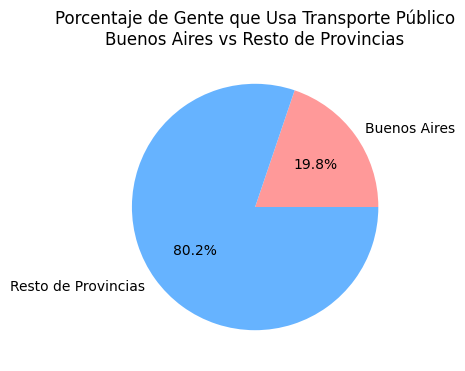

In [72]:
# Crear los datos para el gráfico de pastel
labels = ['Buenos Aires', 'Resto de Provincias']
sizes = [ba_cantidad, resto_cantidad]
colors = ['#ff9999','#66b3ff'] # Colores personalizados para Buenos Aires y Resto de Provincias

# Crear el gráfico de pastel
plt.figure(figsize=(6, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

# Añadir título
plt.title('Porcentaje de Gente que Usa Transporte Público\nBuenos Aires vs Resto de Provincias')
plt.show()

Podemos concluir que el interior supera el uso de transporte público.

Veamos la proporción de uso de cada transporte público en AMBA que calculamos anteriormente de manera gráfica.

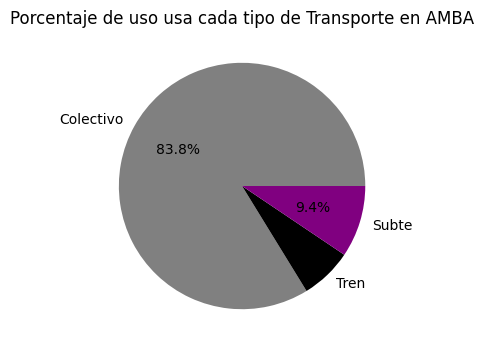

In [73]:
# Crear los datos para el gráfico de pastel
labels = ['Colectivo', 'Tren', 'Subte']
colors = ['grey','black','purple'] 

# Crear el gráfico de pastel
plt.figure(figsize=(6, 4))
plt.pie(proporcion_por_transporte, labels=labels, colors=colors, autopct='%1.1f%%')

# Añadir título
plt.title('Porcentaje de uso usa cada tipo de Transporte en AMBA')
plt.show()

Podemos ver la gran diferencia. Esto era un resultado esperado.

<Figure size 1000x500 with 0 Axes>

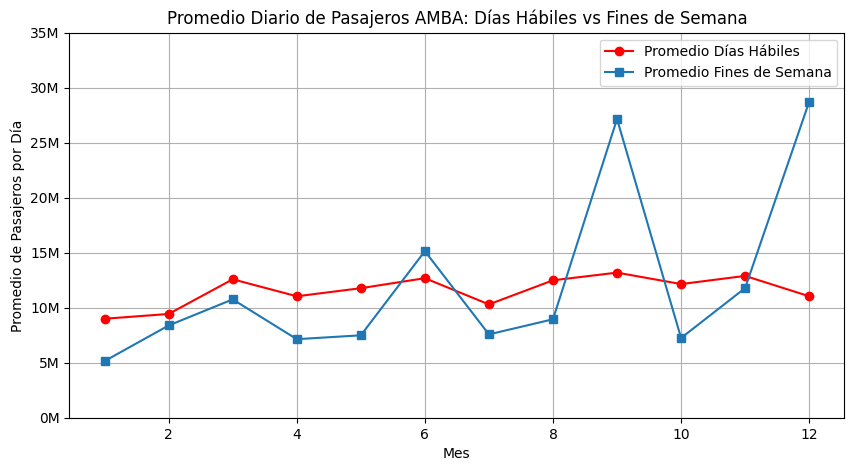

In [74]:

# Lista de nombres de columnas en el orden deseado
orden_columnas = ['DIA_TRANSPORTE', 'FECHA_DIA', 'FECHA_MES','FECHA_ORDINAL','JURISDICCION','LINEA','CANTIDAD','TIPO_TRANSPORTE']


dias_habiles = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
fin_de_semana= ['Sat','Sun']
#Notar que un feriado que caiga dia de semana, es dia habil

# que la columna 'fecha' esté en formato de fecha
datos_amba['fecha'] = pd.to_datetime(datos_amba['fecha'])

# Extraer el mes de la fecha y crear una nueva columna 'mes'
datos_amba['mes'] = datos_amba['fecha'].dt.month

#---------------------------
# Para días hábiles
datos_habiles = datos_amba[datos_amba['fecha_dia'].isin(dias_habiles)]
suma_por_transporte_mes = datos_habiles.groupby(['mes', 'tipo_transporte'])['pasajeros'].sum()
# Para fines de semana
datos_fin_de_semana = datos_amba[datos_amba['fecha_dia'].isin(fin_de_semana)]
suma_por_transporte_fin_de_semana_mes = datos_fin_de_semana.groupby(['mes', 'tipo_transporte'])['pasajeros'].sum()

#-------------------------------
# Si quieres el total mensual de todos los tipos de transporte, puedes sumar todos los valores en 'suma_por_transporte_mes'
total_mensual = suma_por_transporte_mes.groupby('mes').sum()
# para la proporción mensual por tipo de transporte
#proporcion_por_transporte_mes = suma_por_transporte_mes.groupby(level=0).apply(lambda x: x / x.sum())

# Calcular el total mensual para días hábiles y fines de semana
total_mensual_dias_habiles = suma_por_transporte_mes.groupby('mes').sum()
total_mensual_fin_de_semana = suma_por_transporte_fin_de_semana_mes.groupby('mes').sum()

# Calcular el número de días hábiles y fines de semana en cada mes
dias_por_mes = {mes: np.busday_count(f'2024-{mes:02d}-01', f'2024-{mes:02d}-{calendar.monthrange(2024, mes)[1]}') for mes in range(1, 13)}
fines_de_semana_por_mes = {mes: 8 - calendar.monthrange(2024, mes)[0] for mes in range(1, 13)}

# Calcular el promedio diario para días hábiles y fines de semana
promedio_dias_habiles = total_mensual_dias_habiles / pd.Series(dias_por_mes)
promedio_fin_de_semana = total_mensual_fin_de_semana / pd.Series(fines_de_semana_por_mes)

#--------------------------------
# gráfico de líneas para los promedios
plt.figure(figsize=(10, 5))

# Cambiar el color de fondo

# Función para formatear las etiquetas en millones
def millones(x, pos):
    return '%1.0fM' % (x*1e-6)

formatter = FuncFormatter(millones)

plt.figure(figsize=(10, 5))
plt.plot(promedio_dias_habiles, label='Promedio Días Hábiles', marker='o', color="red")
plt.plot(promedio_fin_de_semana, label='Promedio Fines de Semana', marker='s')
plt.title('Promedio Diario de Pasajeros AMBA: Días Hábiles vs Fines de Semana')
plt.xlabel('Mes')
plt.ylabel('Promedio de Pasajeros por Día')

# Establecer el formateador personalizado para el eje Y
plt.gca().yaxis.set_major_formatter(formatter)

# Establecer los límites del eje Y y los ticks
plt.ylim(0, 35000000)
plt.yticks(range(0, 35000001, 5000000))

plt.legend()
plt.grid(True)
plt.show()

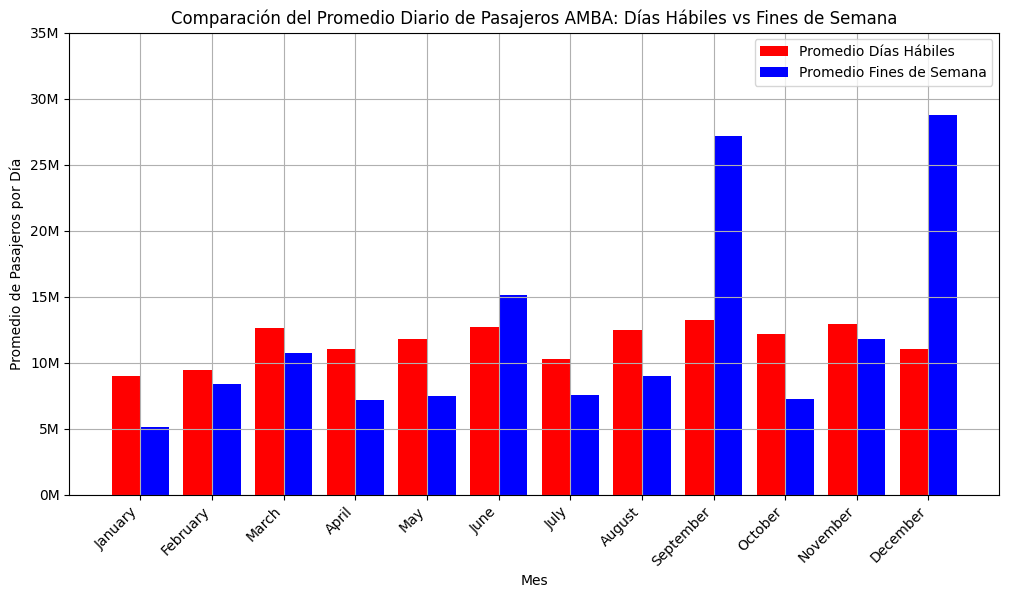

In [75]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Definir la posición de las barras en el eje X
posiciones_dias_habiles = np.arange(len(promedio_dias_habiles))
posiciones_fin_de_semana = [x + 0.4 for x in posiciones_dias_habiles]

# Gráfico de barras para los promedios
ax.bar(posiciones_dias_habiles, promedio_dias_habiles, width=0.4, label='Promedio Días Hábiles', color='red')
ax.bar(posiciones_fin_de_semana, promedio_fin_de_semana, width=0.4, label='Promedio Fines de Semana', color='blue')

# Formatear el gráfico
ax.set_title('Comparación del Promedio Diario de Pasajeros AMBA: Días Hábiles vs Fines de Semana')
ax.set_xlabel('Mes')
ax.set_xticks([x + 0.2 for x in posiciones_dias_habiles])
ax.set_xticklabels([calendar.month_name[mes] for mes in range(1, 13)])
ax.set_ylabel('Promedio de Pasajeros por Día')
ax.yaxis.set_major_formatter(formatter)
# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45, ha='right')

# Establecer los límites del eje Y y los ticks
ax.set_ylim(0, 35000000)
ax.set_yticks(range(0, 35000001, 5000000))

# Agreagamos leyenda y grid
ax.legend()
ax.grid(True)
plt.show()


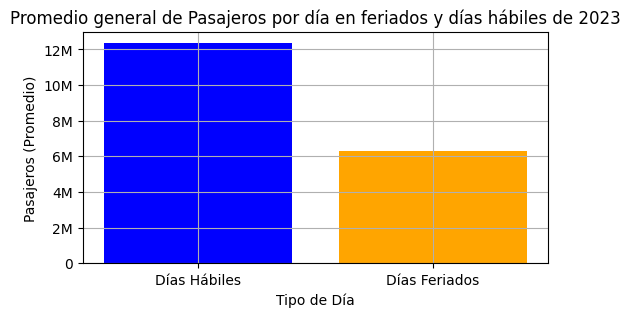

In [76]:
# Lista de fechas de feriados en Argentina para el año 2023 en formato 'YYYY-MM-DD'

feriados = [
    '2023-01-01',  # Año Nuevo
    '2023-02-20',  # Carnaval
    '2023-02-21',  # Carnaval
    '2023-03-24',  # Día Nacional de la Memoria por la Verdad y la Justicia
    '2023-04-02',  # Día del Veterano y de los Caídos en la Guerra de Malvinas
    '2023-04-07',  # Viernes Santo
    '2023-05-01',  # Día del Trabajador
    '2023-05-25',  # Día de la Revolución de Mayo
    '2023-06-17',  # Paso a la Inmortalidad del General Martín Miguel de Güemes
    '2023-06-20',  # Paso a la Inmortalidad del General Manuel Belgrano
    '2023-07-09',  # Día de la Independencia
    '2023-08-17',  # Paso a la Inmortalidad del General José de San Martín
    '2023-10-12',  # Día del Respeto a la Diversidad Cultural
    '2023-11-20',  # Día de la Soberanía Nacional
    '2023-12-08',  # Inmaculada Concepción de María
    '2023-12-25',  # Navidad
]

# Convertir la lista en un conjunto para una búsqueda más rápida
feriados_set = set(feriados)

# Crear una nueva columna 'FERIADO' que será True si la fecha está en la lista de feriados
datos['FERIADO'] = datos['DIA_TRANSPORTE'].apply(lambda x: x.strftime('%Y-%m-%d') in feriados_set)

# Agrupar los datos por feriado y sumar la cantidad
datos_feriado = datos.groupby('FERIADO')['CANTIDAD'].sum().reset_index()

# Función para formatear los valores del eje Y
def millones(x, pos):
    'El valor en el eje Y será formateado a "M" si es un millón o más, y a "K" si está en miles.'
    if x >= 1e6:  # Si el valor es un millón o más
        return f'{int(x * 1e-6)}M'
    elif x >= 1e3:  # Si el valor está en miles
        return f'{int(x * 1e-3)}K'
    else:  # Si el valor es menor a mil
        return int(x)

formatter = FuncFormatter(millones)

# Calcular el promedio de pasajeros para días feriados y días normales
datos_feriado.loc[datos_feriado['FERIADO'] == True, 'PROMEDIO'] = datos_feriado['CANTIDAD'] / 16
datos_feriado.loc[datos_feriado['FERIADO'] == False, 'PROMEDIO'] = datos_feriado['CANTIDAD'] / (365 - 16)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(6, 3))

# Gráfico de barras para el promedio
ax.bar(['Días Hábiles', 'Días Feriados'], datos_feriado['PROMEDIO'], color=['blue', 'orange'])

# Formatear el gráfico
ax.set_title('Promedio general de Pasajeros por día en feriados y días hábiles de 2023')
ax.set_xlabel('Tipo de Día')
ax.set_ylabel('Pasajeros (Promedio)')
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)
plt.show()

En el gráfico podemos ver el promedio de Pasajeros por día en días feriados vs días hábiles (incluyendo fines de semana) en 2023. Y podemos interpretar que se usan aproximadamente un 50% menos.

Hagamos ahora un analisis mas detallado de la provinica de Buenos Aires, siendo esta la que mayor cantidad de gente representa en el pais.

In [77]:
# Filtrar los datos únicamente para la provincia de Buenos Aires
buenos_aires_data = datos_JN_BsAs[datos_JN_BsAs['PROVINCIA'] == 'BUENOS AIRES']

# Calcular la cantidad de pasajeros por municipio
pasajeros_por_municipio = buenos_aires_data.groupby('MUNICIPIO')['CANTIDAD'].sum().reset_index()
pasajeros_por_municipio = pasajeros_por_municipio.sort_values(by='CANTIDAD', ascending=False)

# Visualizar la cantidad de pasajeros por municipio
print("Cantidad de Pasajeros por Municipio en la Provincia de Buenos Aires:")
print(pasajeros_por_municipio.to_string(index=False))

Cantidad de Pasajeros por Municipio en la Provincia de Buenos Aires:
                 MUNICIPIO   CANTIDAD
                        SD 1704254694
                        SN  938240515
        GENERAL PUEYRREDON   79905405
                LA MATANZA   68030525
           LOMAS DE ZAMORA   63894563
           ALMIRANTE BROWN   56936382
                  LA PLATA   53680435
                    MORENO   51631521
                     MERLO   46361575
                     TIGRE   40858337
                     PILAR   33615100
              BAHIA BLANCA   27013511
        ESTEBAN ECHEVERRIA   26985091
                   QUILMES   25293374
                     LANUS   22036951
               JOSE C. PAZ   21444112
          FLORENCIO VARELA   21359288
                SAN ISIDRO   14810003
               BERAZATEGUI   12343806
                    EZEIZA   12024706
                SAN MIGUEL   11621554
                   ESCOBAR   11417353
        GENERAL SAN MARTIN   10859728
SAN NICOLAS DE LOS 

In [78]:
print(f"Cantidad de lineas en la Provincia Buenos Aires: {len(buenos_aires_data['LINEA'].unique())}")

Cantidad de lineas en la Provincia Buenos Aires: 549


In [79]:
# Agrupar los datos por municipio y línea y contar el número de líneas únicas
lineas_por_municipio = buenos_aires_data.groupby(['MUNICIPIO'])['LINEA'].nunique().reset_index()
lineas_por_municipio = lineas_por_municipio.sort_values(by='LINEA', ascending=False).rename(columns={'LINEA': 'CANTIDAD DE LINEAS'})

# Visualizar la cantidad de líneas por municipio en la provincia de Buenos Aires
print(lineas_por_municipio.to_string(index=False))

                 MUNICIPIO  CANTIDAD DE LINEAS
                        SD                 165
                        SN                 138
        GENERAL PUEYRREDON                  48
              BAHIA BLANCA                  18
           LOMAS DE ZAMORA                  14
                    ZARATE                  12
          FLORENCIO VARELA                  12
                   ESCOBAR                  10
SAN NICOLAS DE LOS ARROYOS                  10
                 OLAVARRIA                  10
                  NECOCHEA                  10
                  LA PLATA                  10
           ALMIRANTE BROWN                   8
           CORONEL ROSALES                   8
                     PILAR                   7
                     LANUS                   7
                   QUILMES                   6
                    TANDIL                   6
              VILLA GESELL                   6
                LA MATANZA                   6
             

In [80]:
# Calcular las líneas que más pasajeros mueven en la provincia de Buenos Aires
lineas_mas_pasajeros = buenos_aires_data.groupby('LINEA')['CANTIDAD'].sum().reset_index()
lineas_mas_pasajeros = lineas_mas_pasajeros.sort_values(by='CANTIDAD', ascending=False)

In [81]:
# Visualizar las líneas que más pasajeros mueven en la provincia de Buenos Aires
print("\nLíneas que mas Pasajeros Mueven en la Provincia de Buenos Aires:")
print(lineas_mas_pasajeros.head(20).to_string(index=False))


Líneas que mas Pasajeros Mueven en la Provincia de Buenos Aires:
              LINEA  CANTIDAD
          FFCC ROCA 124801387
           FFCC SAR  68972328
    BSAS_LINEA_501G  51631521
     BSAS_LINEA_203  38593343
     BSAS_LINEA_060  34872974
     BSAS_LINEA_365  34386747
     BSAS_LINEA_440  33502579
     BSAS_LINEA_324  31485572
FFCC_BELGRANO_NORTE  30367411
          FFCC_SANM  30093686
    BSAS_LINEA_501C  26985091
     BSAS_LINEA_620  26226878
     BSAS_LINEA_236  26091753
           LINEA 28  25169676
     BSAS_LINEA_152  24152496
    FCC MITRE_TIGRE  23038093
     BSAS_LINEA_242  22879688
     BSAS_LINEA_021  22537649
     BSAS_LINEA_148  22277404
     BSAS_LINEA_266  21803203


In [82]:
# Visualizar las líneas que menos pasajeros mueven en la provincia de Buenos Aires
print("\nLíneas que menos Pasajeros Mueven en la Provincia de Buenos Aires:")
print(lineas_mas_pasajeros.tail(20).to_string(index=False))


Líneas que menos Pasajeros Mueven en la Provincia de Buenos Aires:
                     LINEA  CANTIDAD
  FFCC_ROCA_CAÑUELAS-LOBOS     16748
                LINEA RZ-9     16643
            BSAS_LINEA_513     13308
                 LINEA_510     11264
         LINEA_455_LANCHAS      9090
                 LINEA 524      9058
FFCC SAR MORENO - MERCEDES      8503
                LINEA RZ-6      5594
         LINEA_454_LANCHAS      3680
           LINEA_517N_BSAS      2629
                 LINEA 600      2226
         LINEA_452_LANCHAS      1577
      LINEA C MONTE RINCON      1456
        LINEA D CEMENTERIO      1321
           LINEA_515N_BSAS      1175
         LINEA_451_LANCHAS       799
                        2A       354
     FFCC_G.CATAN_MERCEDES       245
            BSAS_LINEA_446        24
                 LINEA 521         2


In [83]:
# Calcular las empresas con mas lineas pasajeros en la provincia de Buenos Aires
lineas_mas_pasajeros = buenos_aires_data.groupby('NOMBRE_EMPRESA')['CANTIDAD'].sum().reset_index()

# Calcular la cantidad de líneas por empresa
lineas_por_empresa = buenos_aires_data.groupby('NOMBRE_EMPRESA')['LINEA'].nunique().reset_index()
lineas_por_empresa = lineas_por_empresa.rename(columns={'LINEA': 'CANTIDAD DE LINEAS'})

# Fusionar el DataFrame de líneas por empresa con el DataFrame de líneas más pasajeros
lineas_mas_pasajeros = lineas_mas_pasajeros.merge(lineas_por_empresa, on='NOMBRE_EMPRESA')

# Visualizar las líneas que más pasajeros mueven en la provincia de Buenos Aires
print("\nLíneas que mas Pasajeros Mueven en la Provincia de Buenos Aires:")
print(lineas_mas_pasajeros.sort_values(by='CANTIDAD', ascending=False).to_string(index=False))


Líneas que mas Pasajeros Mueven en la Provincia de Buenos Aires:
                                                                         NOMBRE_EMPRESA  CANTIDAD  CANTIDAD DE LINEAS
                                                                           SOFSE - Roca 125243350                   5
                                                           TRANSPORTES LA PERLITA S.A.   91144040                   7
                                                               EMPRESA LINEA 216 S.A.T.  85937290                   9
                                                                       SOFSE- SARMIENTO  70030059                   3
                                                                         LA CABAÑA S.A.  66374356                   7
                                                         GENERAL TOMAS GUIDO S.A.C.I.F.  62128231                   9
                                               EMPRESA DE TRANSPORTE PERALTA RAMOS SACI  59352064           

## Modelado

### Preparacion del Dataset

In [84]:
df = pd.read_csv('./sube-2023-regresion.csv')

In [85]:
df.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323326 entries, 0 to 323325
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   323326 non-null  object
 1   NOMBRE_EMPRESA   323326 non-null  object
 2   LINEA            323326 non-null  object
 3   AMBA             323326 non-null  object
 4   TIPO_TRANSPORTE  323326 non-null  object
 5   JURISDICCION     321581 non-null  object
 6   PROVINCIA        321566 non-null  object
 7   MUNICIPIO        321566 non-null  object
 8   CANTIDAD         323326 non-null  int64 
 9   DATO_PRELIMINAR  323326 non-null  object
dtypes: int64(1), object(9)
memory usage: 24.7+ MB


*(a) Generar un DataFrame en el que las columnas sean las líneas de colectivo (TIPO_TRANSPORTE
== "COLECTIVO") de AMBA de jurisdicción nacional (PROVINCIA == "JN") y las observaciones sean los días del año. Es decir, cada fila del DataFrame corresponde a un día
del año, y en esa fila deben figurar la cantidad de pasajeros que viajaron en cada línea de
colectivo en el día correspondiente.*

In [87]:
datos_ColectivoJN = df[(df['TIPO_TRANSPORTE'] == 'COLECTIVO') & (df['PROVINCIA'] == 'JN')]
datos_ColectivoJN.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
8,2023-01-01,TRANSPORTES LINEA 123 S.A.C.I.,BS_ASLINEA_123,SI,COLECTIVO,NACIONAL,JN,SD,1681,NO
9,2023-01-01,TRANPORTES VEINTIDOS DE SETIEMBRE S.A.C.,BSAS_LINEA_002,SI,COLECTIVO,NACIONAL,JN,SD,5670,NO
10,2023-01-01,GENERAL TOMAS GUIDO S.A.C.I.F.,BSAS_LINEA_009,SI,COLECTIVO,NACIONAL,JN,SD,5644,NO
11,2023-01-01,LINEA 10 S.A.,BSAS_LINEA_010,SI,COLECTIVO,NACIONAL,JN,SD,5177,NO
12,2023-01-01,TRANSPORTES SUR-NOR C.I.S.A.,BSAS_LINEA_015,SI,COLECTIVO,NACIONAL,JN,SD,9109,NO


In [88]:
cols = datos_ColectivoJN.LINEA.unique()
pasajeros_por_linea = pd.DataFrame()

for col in cols:
    datos_linea = datos_ColectivoJN[datos_ColectivoJN.LINEA == col ][["DIA_TRANSPORTE", "CANTIDAD"]]
    datos_linea = datos_linea.set_index("DIA_TRANSPORTE").rename(columns = {"CANTIDAD" : col })
    pasajeros_por_linea = pd.concat ([pasajeros_por_linea, datos_linea ], axis = 1)

pasajeros_por_linea.head()

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA_099,LINEA_119_AMBA,LINEA_164_AMBA,LINEA_902,LINEA_906,LINEA_910_STAFE,LINEA_915_STAFE,STAFE_SANTA FE_LINEA_907,LINEA 908,LINEA 119
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1681,5670,5644,5177,9109,7013,1604,2617,11235,2202,...,1882,1573.0,3210,5310.0,497,4916,30.0,737,NaN,NaN
2023-01-02,9440,21759,23284,21176,45269,29962,13921,11934,55611,13823,...,10322,7345.0,19362,3474.0,1527,10466,307.0,1652,873.0,NaN
2023-01-04,10540,24755,25405,23806,52873,33659,16172,13366,61721,16206,...,11981,7925.0,21784,3500.0,1724,11938,497.0,1368,921.0,NaN
2023-01-05,10408,25772,26489,24688,53436,35182,16569,12929,62510,16863,...,11787,7597.0,22972,3746.0,1923,12246,467.0,1300,930.0,NaN
2023-01-06,10530,26021,26458,24167,53163,35212,16459,12955,63528,16846,...,11567,7811.0,23411,4477.0,2128,13143,576.0,1653,905.0,NaN


In [89]:
pasajeros_por_linea.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 2023-01-01 to 2023-12-30
Columns: 146 entries, BS_ASLINEA_123 to LINEA 119
dtypes: float64(17), int64(129)
memory usage: 295.2+ KB


*(b) Eliminar las columnas correspondientes a líneas de colectivo que tengan datos faltantes.*

In [90]:
# Identificar columnas con datos vacíos (NaN)
columnas_con_nan = pasajeros_por_linea.columns[pasajeros_por_linea.isna().any()].tolist()
print(f'Cantiad de lineas de colectivo que van a ser removidas: {len(columnas_con_nan)}')

# Eliminar las columnas con datos vacíos excepto 'DIA_TRANSPORTE'
pasajeros_por_linea = pasajeros_por_linea.drop(columns=columnas_con_nan)

# Chequeo
columnas_con_nan = pasajeros_por_linea.columns[pasajeros_por_linea.isna().any()].tolist()
print(f'Lineas con filas vacias: {len(columnas_con_nan)}')

Cantiad de lineas de colectivo que van a ser removidas: 17
Lineas con filas vacias: 0


*(c) Se quiere ajustar la cantidad de pasajeros en la línea BSAS_LINEA_009 en función de los
pasajeros en otras líneas. Proponer tres modelos de regresión distintos. En cada modelo,
pueden utilizarse la información solo de otras 5 líneas de colectivos (pueden ser distintas
líneas de colectivo en los distintos modelos). Los criterios de selección de esas 5 columnas
los determinan ustedes, y deben estar explicitados en el informe.*

In [91]:
# Entendamos mejor la linea en cuestion, BSAS_LINEA_009.
datos_BSAS_009 = datos_ColectivoJN[datos_ColectivoJN['LINEA'] == 'BSAS_LINEA_009']
datos_BSAS_009

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
10,2023-01-01,GENERAL TOMAS GUIDO S.A.C.I.F.,BSAS_LINEA_009,SI,COLECTIVO,NACIONAL,JN,SD,5644,NO
938,2023-01-02,GENERAL TOMAS GUIDO S.A.C.I.F.,BSAS_LINEA_009,SI,COLECTIVO,NACIONAL,JN,SD,23284,NO
2136,2023-01-04,GENERAL TOMAS GUIDO S.A.C.I.F.,BSAS_LINEA_009,SI,COLECTIVO,NACIONAL,JN,SD,25405,NO
3339,2023-01-05,GENERAL TOMAS GUIDO S.A.C.I.F.,BSAS_LINEA_009,SI,COLECTIVO,NACIONAL,JN,SD,26489,NO
4547,2023-01-06,GENERAL TOMAS GUIDO S.A.C.I.F.,BSAS_LINEA_009,SI,COLECTIVO,NACIONAL,JN,SD,26458,NO
...,...,...,...,...,...,...,...,...,...,...
316724,2023-12-22,GENERAL TOMAS GUIDO S.A.C.I.F.,BSAS_LINEA_009,SI,COLECTIVO,NACIONAL,JN,SD,26684,NO
318068,2023-12-23,GENERAL TOMAS GUIDO S.A.C.I.F.,BSAS_LINEA_009,SI,COLECTIVO,NACIONAL,JN,SD,19188,NO
319365,2023-12-27,GENERAL TOMAS GUIDO S.A.C.I.F.,BSAS_LINEA_009,SI,COLECTIVO,NACIONAL,JN,SD,24693,NO
320705,2023-12-29,GENERAL TOMAS GUIDO S.A.C.I.F.,BSAS_LINEA_009,SI,COLECTIVO,NACIONAL,JN,SD,27200,NO


In [92]:
print(f'Empresas a cargo de la linea: {datos_BSAS_009.NOMBRE_EMPRESA.unique()}')
print(f'Municipios por donde pasa la linea: {datos_BSAS_009.MUNICIPIO.unique()}')

Empresas a cargo de la linea: ['GENERAL TOMAS GUIDO S.A.C.I.F.']
Municipios por donde pasa la linea: ['SD']


#### Análisis de Recorridos de Autobuses en Buenos Aires

##### Recorrido Principal: Línea 9 (A y B)

La **Línea 9** cuenta con dos recorridos principales, **A** y **B**. Aunque la información sobre las divisiones específicas de cada línea no está explícitamente detallada, podemos realizar aproximaciones basadas en puntos geográficos clave.

*Conjunto 1: Similares al Recorrido A*

El recorrido más importante es el **A**, que pasa por **Retiro** y lugares importantes como el **Obelisco**. Estos puntos son cruciales en el tráfico de autobuses debido a su ubicación estratégica. Para nuestra predicción, seleccionaremos las siguientes líneas que comparten similitudes con este recorrido:

- **LINEA 8**
- **BSAS_LINEA_017**
- **LINEA 33**
- **BSAS_LINEA_045**
- **BSAS_LINEA_067**

*Conjunto 2: Similares al Recorrido B*

Elegimos líneas cuyos recorridos son parecidos al de la **Línea 9 Recorrido B**. Estas líneas aún no han sido consideradas y son:

- **BSAS_LINEA_070**
- **BSAS_LINEA_093**
- **BSAS_LINEA_095**
- **BSAS_LINEA_100**
- **BSAS_LINEA_111**

*Conjunto 3: Similares al Recorrido A que pasen por Retiro y esten en Capital*

Proponemos líneas que solo lleguen a Retiro y en general transiten por Capital. Aqui se asemejaria a lo que es el recorrido de la linea 9A, tanto en caudal de gente como en lugares visitados.

- **BSAS_LINEA_19**
- **BSAS_LINEA_020**
- **BSAS_LINEA_021**
- **BSAS_LINEA_022**
- **LINEA 7**


### Preprocesamiento De Los Datos

- Eliminar 'Outliers' de las columnas numericas.
- Rellenar los valores de los 'Outliers' removidos.
- Separar los datos en set de 'entrenamiento' y 'testeo'.
- Escalado de las variables de entrenamiento.

Vale aclarar, las columnas con valores nulos han sido removidas recientemente (por eso se rellena con la mediana a los 'nuevos nulos' que quedan despues de remover los 'Outliers').
Despues, se va a entrenar cada uno de los 3 modelos seleccionados con cada una de las combinaciones de 5 lineas elejidas previamente. Por esto, vamos a tener que hacer el
preprocesamiento de varios DataFrames distintos, asi que vamos a definir una funcion 'preprocesamiento()', con la finalidad de reutilizarla y no repetir codigo innecesariamente.

In [93]:
def remover_outliers(datos: pd.DataFrame):
    """
    Remueve outliers de un DataFrame utilizando el método IQR.
    """
    Q1 = datos.quantile(0.25)
    Q3 = datos.quantile(0.75)
    IQR = Q3 - Q1
    filter = ~((datos < (Q1 - 1.5 * IQR)) | (datos > (Q3 + 1.5 * IQR))).any(axis=1)
    return datos[filter]

def rellenar_vacios(datos: pd.DataFrame):
    """
    Rellena los valores nulos en un DataFrame con la mediana de cada columna.
    """
    for column in datos.columns:
        if datos[column].isnull().sum() > 0:
            datos[column].fillna(datos[column].median(), inplace=True)
    return datos

def escalado(X_train: pd.DataFrame, X_test: pd.DataFrame):
    """
    Escala las variables del conjunto de datos usando StandardScaler.
    """
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [94]:
def preprocesamiento(lineas: list, target: str, dataset: pd.DataFrame):
    """
    Esta funcion se encarga de hacer los distintos pasos
    necesarios para un correcto preprocesamiento de los
    datos. 

    Inputs
    ------
    linea: list[str]
        Lista con las lineas a mantener.
    target: str
        Linea a predecir.
    dataset: pd.DataFrame
        DataFrame a utilizar.
    
    Outputs
    -------
    X_train: np.ndarray
        Datos de entrenamientio.
    X_test: np.ndarray
        Datos de testeo.
    y_train: pd.Series
        Resultados de 'X_train'.
    y_test: pd.Series
        Resultados de 'X_test'.
    """

    # Filtramos el Dataset
    datos = dataset[lineas]

    # Removemos 'Outliers'
    datos = remover_outliers(datos)

    # Rellenamos los datos de los 'Outliers'
    n = datos.isnull().sum()
    nulos = datos.isnull().sum().sum()
    if nulos != 0:
        rellenar_vacios(datos)

    # Separamos el Dataset
    x = pasajeros_por_linea[lineas] 
    y = pasajeros_por_linea[target]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

    # Escalado de las variables
    X_train, X_test = escalado(X_train, X_test)

    return X_train, X_test, y_train, y_test


In [95]:
# Combinaciones de Lineas
lineas_A = ['LINEA 8', 'BSAS_LINEA_017', 'LINEA 33', 'BSAS_LINEA_045', 'BSAS_LINEA_067']
lineas_B = ['BSAS_LINEA_070', 'BSAS_LINEA_093', 'BSAS_LINEA_095', 'BSAS_LINEA_100', 'BSAS_LINEA_111']
lineas_retiro = ['BSAS_LINEA_019', 'LINEA 7', 'BSAS_LINEA_020', 'BSAS_LINEA_021', 'BSAS_LINEA_022']

# Linea Target
target = 'BSAS_LINEA_009'

# Datos preprocesados
X_train_A, X_test_A, y_train_A, y_test_A = preprocesamiento(lineas_A, target, pasajeros_por_linea)
X_train_B, X_test_B, y_train_B, y_test_B = preprocesamiento(lineas_B, target, pasajeros_por_linea)
X_train_retiro, X_test_retiro, y_train_retiro, y_test_retiro = preprocesamiento(lineas_retiro, target, pasajeros_por_linea)

In [96]:
# Chequeamos que este todo bien con uno de los sets de Datos
print(X_train_A.shape)
print(X_test_A.shape)
print(y_train_A.shape)
print(y_test_A.shape)

(175, 5)
(75, 5)
(175,)
(75,)


### Entrenamiento y Testeo

En este ultimo paso vamos a entrenar 3 modelos de regresion lineal, veamos cada uno de ellos:

- Regresor Lineal
- Ridge
- Regresor SGD 

Aclaracion, el 'Regresor Lineal' es el modelo de regresión lineal estándar. Despues, 'Ridge', es una variante de la regresión lineal que incluye regularización, que se puede ajustar con el hiperparametro 'L2', y por su parte 'Regresor SGD' tambien es una variante del clasico regresor lineal (se entrena usando el descenso de gradiente estocastico, de ahi el nombre 'SGD'), que tiene ademas del regularizador 'L2', el 'L1' y el 'Elastic Net', este ulltimo es una combinacion de los otros 2 previamente mencionados.

Vamos a hacer una primera prueba en donde usamos el Regresor Lineal clasico y lo entrenamos sin usar validacion cruzada, y despues con, para comparar la eficacicia de usar este enfoque mencionado. Vamos a usar la metrica de MSE para medir los resultados del modelo. Despues, vamos a utilzar el metodo 'GridSearchCV()' de scikit-learn para poder buscar las distintas combinacions de hiperparametros mas optimos para cada modelo lineal, con particular enfasis en los regularizadores mencionados.

In [97]:
# Enfoque 'Naive' sin CV
lr = LinearRegression() 
lr.fit(X_train_A, y_train_A)

# Test Set
y_pred_test = lr.predict(X_test_A)
error_test = metrics.mean_squared_error(y_test_A, y_pred_test)

print(f"Test MSE Error {error_test})")

Test MSE Error 12598948.619118445)


Analizemos entrenando con validacion cruzada con el metodo 'cross_val_score()' que nos ofrece scikit-learn.

In [98]:
# Entrenar el modelo con validación cruzada y obtener los puntajes
cv_scores = cross_val_score(lr, X_train_A, y_train_A, scoring='neg_mean_squared_error') # 5 CV siendo ejecutados por default

# Convertir los puntajes a positivos para interpretabilidad
cv_scores = -cv_scores

# Mostrar los puntajes de validación cruzada
print(f'Puntajes de validación cruzada (MSE): {cv_scores}')
print(f'Promedio de los puntajes de validación cruzada (MSE): {np.mean(cv_scores)}')

Puntajes de validación cruzada (MSE): [ 4011245.2145234  12168463.33007713 13020144.79272615  9391214.25830602
 16078477.97034582]
Promedio de los puntajes de validación cruzada (MSE): 10933909.113195706


Notemos que con el simple hecho de utilizar la tecnica menioncada nuestro modelo mejoro alrededor de un 20%.

*(d) Si alguno de los modelos es Regresión Ridge, determinar mediante un esquema de validación el hiperparámetro α.*

*(e) Proponer un esquema de validación de los modelos y utilizarlo para seleccionar el mejor
de los tres modelos propuestos.*

Hagamos ahora una funcion para hacer los disintos entrenamientos de cada uno de los modelos para cada combinacion distinta de lineas e hiperparametros. Vamos a aprovechar para ir guardando de forma automatica cada uno de los resultados de los entrenamientos en un DataFrame para poder compararlos una vez finalizada esta etapa.

In [99]:
def entrenamiento(modelos: dict, X_train: np.ndarray, y_train: pd.Series, lineas: list[str]):
    """
    Ejecuta el entrenamiento con GridSearchCV y validacion cruzada 
    para los modelos y datos de entrenamiento recibidos. Además,
    se incorpora la funcionalidad para que almacene los resultados
    en un DataFrame para un futuro análisis de ellos, y devuelve
    el mejor modelo.

    Inputs
    ------
    modelos: dict
        Diccionario con nombres de modelos como
        claves y una tupla (modelo, hiperparámetros)
        como valores.
    X_train: np.ndarray
        Datos de entrenamiento.
    y_train: pd.Series
        Resultados de los Datos de entrenamiento.
    lineas: list[str]
        Lista de nombres de colectivos.
    
    Outputs
    -------
    resultados: pd.DataFrame
        DataFrame con los resultados del entrenamiento.
    mejor_modelo: dict{sklearn.linear_model}
        El mejor modelo del GridSearch, según la métrica
        de error, para cada uno de ellos.
    """

    # Definir el DataFrame para almacenar los resultados
    resultados = pd.DataFrame(columns=['Modelo', 'Mejores Hiperparámetros', 'Validation Score', 'Lineas'])
    mejores_modelos = {}

    # Configurar validación cruzada con random_state para reproducibilidad
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    for nombre_modelo, (modelo, hiperparametros) in modelos.items():

        # Ajustar random_state en los modelos que lo aceptan
        if 'random_state' in modelo.get_params():
            modelo.set_params(random_state=42)

        # Configurar y ejecutar GridSearchCV
        grid_search = GridSearchCV(estimator=modelo, param_grid=hiperparametros, cv=cv, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        
        # Obtener los mejores hiperparámetros, score y modelo
        mejores_modelos[nombre_modelo] = grid_search.best_estimator_
        mejores_hiperparametros = grid_search.best_params_
        score_val = -grid_search.best_score_ 

        resultado = pd.DataFrame({
            'Modelo': [nombre_modelo],
            'Mejores Hiperparámetros': [mejores_hiperparametros],
            'Validation Score': [score_val],
            'Lineas': [lineas]
        })
        
        resultados = pd.concat([resultados, resultado])
                
    return resultados, mejores_modelos


In [100]:
# Modelos e hiperparámetros
modelos = {
    'Regresor Lineal': (LinearRegression(), {}),
    'Ridge': (Ridge(), {'alpha': [0.01, 0.1]}),
    'Regresor SGD': (SGDRegressor(), {'alpha': [0.0001, 0.001, 0.01, 0.1], 'penalty': ['l1','l2','elasticnet'] ,'max_iter': [10000, 100000]})
}

resultados_A, mejores_modelos_A = entrenamiento(modelos, X_train_A, y_train_A, lineas_A)
resultados_B, mejores_modelos_B = entrenamiento(modelos, X_train_B, y_train_B, lineas_B)
resultados_retiro, mejores_modelos_retiro = entrenamiento(modelos, X_train_retiro, y_train_retiro, lineas_retiro)

resultados = pd.concat([resultados_A, resultados_B, resultados_retiro]).sort_values(by='Validation Score').reset_index(drop=True)
resultados

,Modelo,Mejores Hiperparámetros,Validation Score,Lineas
0,Ridge,{'alpha': 0.1},4.923332e+06,"[BSAS_LINEA_019, LINEA 7, BSAS_LINEA_020, BSAS..."
1,Regresor Lineal,{},4.932114e+06,"[BSAS_LINEA_019, LINEA 7, BSAS_LINEA_020, BSAS..."
2,Regresor SGD,"{'alpha': 0.1, 'max_iter': 10000, 'penalty': '...",5.003631e+06,"[BSAS_LINEA_019, LINEA 7, BSAS_LINEA_020, BSAS..."
3,Regresor Lineal,{},5.259518e+06,"[BSAS_LINEA_070, BSAS_LINEA_093, BSAS_LINEA_09..."
4,Ridge,{'alpha': 0.01},5.259522e+06,"[BSAS_LINEA_070, BSAS_LINEA_093, BSAS_LINEA_09..."
5,Regresor SGD,"{'alpha': 0.0001, 'max_iter': 10000, 'penalty'...",5.378796e+06,"[BSAS_LINEA_070, BSAS_LINEA_093, BSAS_LINEA_09..."
6,Regresor SGD,"{'alpha': 0.1, 'max_iter': 10000, 'penalty': '...",1.029790e+07,"[LINEA 8, BSAS_LINEA_017, LINEA 33, BSAS_LINEA..."
7,Regresor Lineal,{},1.032081e+07,"[LINEA 8, BSAS_LINEA_017, LINEA 33, BSAS_LINEA..."
8,Ridge,{'alpha': 0.01},1.032249e+07,"[LINEA 8, BSAS_LINEA_017, LINEA 33, BSAS_LINEA..."


Notemos que los mejores modelos corresponden todos a una misma combinacion de lineas ('lineas_retiro'), y la diferencia entre modelos no es tan significante como la correcta eleccion de los datos de entrenamiento. Despues, probemos todos los modelos con el set de testeo ya que la diferencie entre ellos es chica.

In [101]:
modelo_rl = mejores_modelos_retiro['Regresor Lineal']
modelo_ridge = mejores_modelos_retiro['Ridge']
modelo_sgd = mejores_modelos_retiro['Regresor SGD']

In [102]:
# Regresor Lineal
y_pred_test = modelo_rl.predict(X_test_retiro)
error_test = metrics.mean_squared_error(y_test_retiro, y_pred_test)
print(f"Test EMC modelo Lineal: {error_test}")

# Ridge
y_pred_test = modelo_ridge.predict(X_test_retiro)
error_test = metrics.mean_squared_error(y_test_retiro, y_pred_test)
print(f"Test EMC modelo Ridge: {error_test}")

# Regresor SGD
y_pred_test = modelo_sgd.predict(X_test_retiro)
error_test = metrics.mean_squared_error(y_test_retiro, y_pred_test)
print(f"Test EMC modelo SGD: {error_test}")

Test EMC modelo Lineal: 4098099.415198857
Test EMC modelo Ridge: 4076527.247992414
Test EMC modelo SGD: 3953760.735928421


El mejor modelos fue el Regresor SGD entrenado con la combinacion de lineas de retiro con un MSE de 3,9M aproximandamente. Notemos con como muy poco esfuerzo pudimos mejorar nuestro primer modelo 'Naive' a este ultimo en aproximadamente un 65% de mejora.

*(f) Para el modelo elegido, indicar la fórmula final de modelo.*

In [103]:
modelo_sgd

SGDRegressor(alpha=0.1, max_iter=10000, penalty='l1', random_state=42)

In [104]:
modelo_sgd.get_params()

{'alpha': 0.1,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 10000,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [105]:
# Obtener los coeficientes e intercepto
coeficientes = modelo_sgd.coef_
intercepto = modelo_sgd.intercept_
print("Coeficientes:", coeficientes)
print("Intercepto:", intercepto)

Coeficientes: [ 124.61184529 6909.43592849  804.70266394 1999.34262045  209.77947082]
Intercepto: [26821.77964369]


La fórmula del modelo del modelo `SGDRegressor` con regularización L1 (Lasso) es:

\begin{equation}
\text{BSAS\_LINEA\_009} = \beta_0 + \sum_{i=1}^5 \beta_i \cdot x_i + \alpha \sum_{i=1}^5 |\beta_i|
\end{equation}

Donde:
\begin{align*}
\beta_0 &= 26821.7796 \\
\beta_1 &= 124.6118 \\
\beta_2 &= 6909.4359 \\
\beta_3 &= 804.7026 \\
\beta_4 &= 1999.3426 \\
\beta_5 &= 209.7794 \\
\alpha &= 0.1 \\
x_1 &= \text{BSAS\_LINEA\_19} \\
x_2 &= \text{BSAS\_LINEA\_020} \\
x_3 &= \text{BSAS\_LINEA\_021} \\
x_4 &= \text{BSAS\_LINEA\_022} \\
x_5 &= \text{LINEA\_7}
\end{align*}

Primero, calculamos la penalización L1:
\begin{equation}
\alpha \sum_{i=1}^5 |\beta_i| = 0.1 \times (|124.6118| + |6909.4359| + |804.7026| + |1999.3426| + |209.7794|)
\end{equation}

Calculamos la suma de los valores absolutos de los coeficientes:
\begin{equation}
|124.6118| + |6909.4359| + |804.7026| + |1999.3426| + |209.7794| = 124.6118 + 6909.4359 + 804.7026 + 1999.3426 + 209.7794 = 10047.8723
\end{equation}

Ahora, multiplicamos esta suma por alpha:
\begin{equation}
0.1 \times 10047.8723 = 1004.78723
\end{equation}

Sustituimos los valores de los coeficientes, el intercepto y la penalización en la fórmula del modelo:
\begin{equation}
\text{BSAS\_LINEA\_009} = 26821.7796 + 124.6118 \cdot x_1 + 6909.4359 \cdot x_2 + 804.7026 \cdot x_3 + 1999.3426 \cdot x_4 + 209.7794 \cdot x_5 + 1004.78723
\end{equation}

Finalmente, sumamos todos los términos para obtener el resultado final. En nuestro caso deberiamos llegar a que el resultado final es:
\begin{equation}
\text{BSAS\_LINEA\_009} = 3953760.735928421
\end{equation}